# Assignment 2 Implementation Questions

In [7]:
import numpy
import torch
import pandas
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.utils
import torch.utils.data
import math

device = "cuda:0"

## Question 1
### Develop a neural network using PyTorch for BMI estimation. Given information about the user, such as their gender, height, and weight, your model should classify the user into one of the BMI indices.

#### a) Load and split your dataset into train and test sets with a 7:3 ratio using methods from PyTorch.

In [3]:
bmi_data = pandas.read_csv("bmi.csv")
bmi_data.loc[bmi_data["Gender"] == "Male", "Gender"] = 1
bmi_data.loc[bmi_data["Gender"] == "Female", "Gender"] = 2
bmi_data = bmi_data.astype(float)
train_data, test_data, train_target, test_target = train_test_split(bmi_data.loc[:, bmi_data.columns != "Index"].to_numpy(),
                                                                    bmi_data["Index"].to_numpy(),
                                                                    test_size=0.3,
                                                                    random_state=42)
train_data_torch = torch.Tensor(train_data)
test_data_torch = torch.Tensor(test_data)
train_target_torch = torch.Tensor(train_target)
test_target_torch = torch.Tensor(test_target)

#### b) Implement and train your neural network. Note and plot the performance in terms of batch vs loss/accuracy across a sufficient number epochs (until convergence if possible).

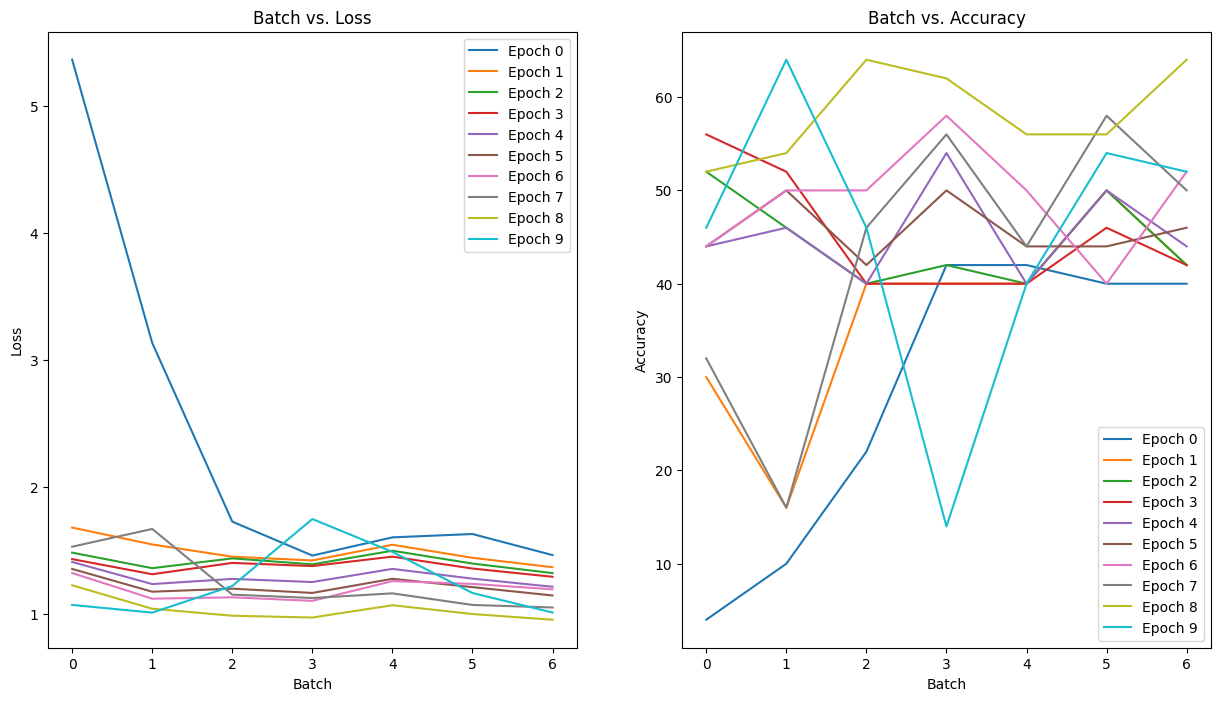

In [4]:
torch.manual_seed(0)

hidden_layer_one_size = train_data_torch.shape[1] * 10
hidden_layer_two_size = hidden_layer_one_size * 2

bmi_neural_network = torch.nn.Sequential(
    torch.nn.Linear(train_data_torch.shape[1], hidden_layer_one_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer_one_size, hidden_layer_two_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer_two_size, hidden_layer_one_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer_one_size, hidden_layer_one_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_layer_one_size, len(bmi_data.Index.unique())),
)
bmi_neural_network.train()

num_epochs = 10

batch_size = 50

learning_rate = 0.01

sgd_optimizer = torch.optim.SGD(bmi_neural_network.parameters(), learning_rate)

cross_entropy_func = torch.nn.CrossEntropyLoss()

training_losses = []

training_accuracies = []

fig, (loss_ax, acc_ax) = plt.subplots(1,2, figsize=(15, 8))

for epoch in range(num_epochs):
    for i in range(0, train_data_torch.shape[0], batch_size):
        X_data_matrix = train_data_torch[i:i+batch_size]
        y_label_vector = train_target_torch[i:i+batch_size]

        sgd_optimizer.zero_grad()

        confidence_scores = bmi_neural_network(X_data_matrix)
        loss = cross_entropy_func(confidence_scores, y_label_vector.long())
        loss.backward()

        sgd_optimizer.step()

        training_losses.append(loss.item())
        
        label_predictions = (torch.nn.Softmax(dim=1))(confidence_scores)
        training_accuracies.append(((torch.argmax(label_predictions, dim=1) == y_label_vector).sum() / len(y_label_vector)) * 100)
    
    loss_ax.plot(numpy.arange(len(training_losses)), training_losses, label=f"Epoch {epoch}")
    loss_ax.set_xlabel("Batch")
    loss_ax.set_ylabel("Loss")
    loss_ax.set_title(f"Batch vs. Loss")
    loss_ax.legend()
    loss_ax.grid()
    
    acc_ax.plot(numpy.arange(len(training_accuracies)), training_accuracies, label=f"Epoch {epoch}")
    acc_ax.set_xlabel("Batch")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.set_title(f"Batch vs. Accuracy")
    acc_ax.legend()
    acc_ax.grid()

    training_losses.clear()
    
    training_accuracies.clear()

plt.show()

#### c) Analyze the performance on the test set using common classification metrics.

In [5]:
bmi_neural_network.eval()

X_data_matrix = test_data_torch
y_label_vector = test_target_torch

confidence_scores = bmi_neural_network(X_data_matrix)
loss = cross_entropy_func(confidence_scores, y_label_vector.long())

label_predictions = (torch.nn.Softmax(dim=1))(confidence_scores)
accuracy = ((torch.argmax(label_predictions, dim=1) == y_label_vector).sum() / len(y_label_vector)) * 100

print(f"Loss on test set: {loss:.2f}")

print(f"Accuracy on test set: {accuracy:.2f}%")

Loss on test set: 0.97
Accuracy on test set: 74.00%


#### d) It is time to fine-tune your model with the aim of enhancing its performance. Implement a grid search considering the learning rate and batch size parameters. Try variations of learning rates (i.e. 0.1, 0.01, 0.001, 0.0001, etc) and batch sizes (8, 16, 32, 64, etc). Compare the results in terms of training curves and testing performance.

In [6]:
learning_rates = [0.2, 0.1, .05, .025, 0.01, 0.001]

batch_sizes = [2**i for i in range(3, 9)]

train_data_torch, val_data_torch, train_target_torch, val_target_torch = train_test_split(train_data_torch,
                                                                                            train_target_torch,
                                                                                            test_size=0.2,
                                                                                            random_state=42)

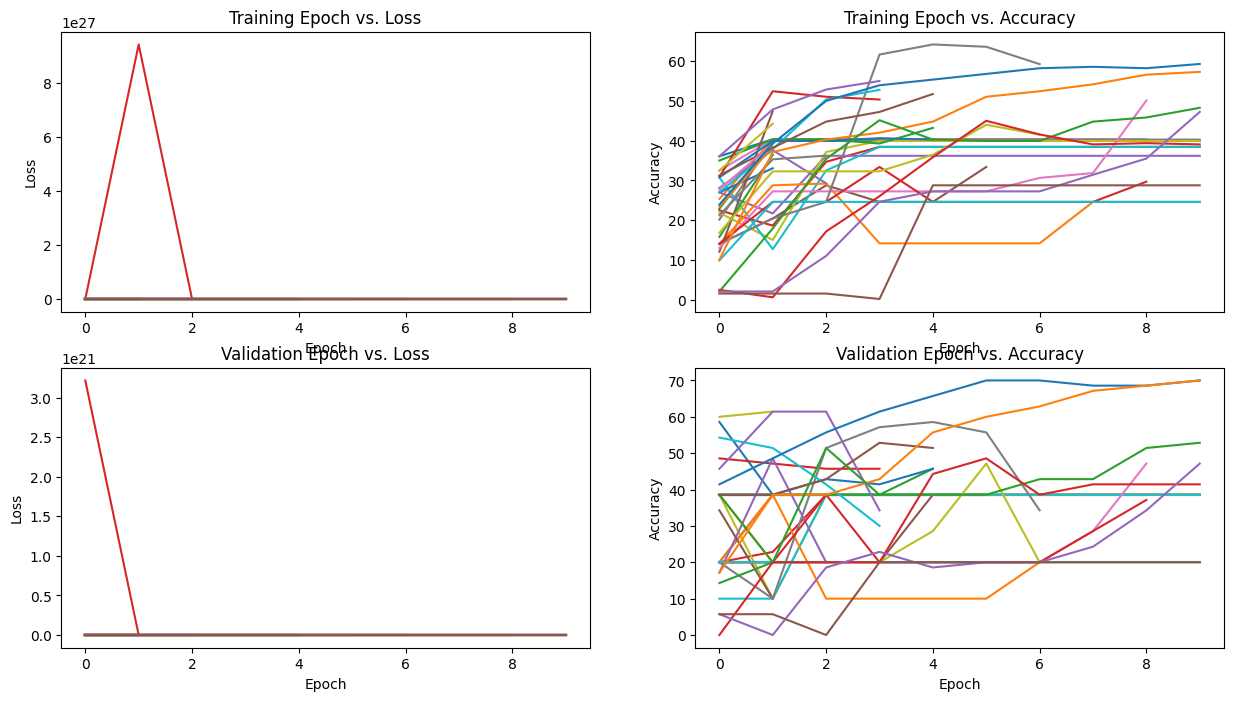

The best loss value that was found was 0.82
Config: learning rate = 0.001, batch size = 8
Loss on test set: 0.78
Accuracy on test set: 74.67%


In [11]:
best_learning_rate = 0.0

best_batch_size = 0

current_optimized_loss = 9999999.99

current_optimized_network = None

fig, ax = plt.subplots(2,2, figsize=(15, 8))

for search_learning_rate in learning_rates:
    for search_batch_size in batch_sizes:
        torch.manual_seed(0)

        hidden_layer_one_size = train_data_torch.shape[1] * 10
        hidden_layer_two_size = hidden_layer_one_size * 2

        bmi_neural_network = torch.nn.Sequential(
            torch.nn.Linear(train_data_torch.shape[1], hidden_layer_one_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layer_one_size, hidden_layer_two_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layer_two_size, hidden_layer_one_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layer_one_size, hidden_layer_one_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_layer_one_size, len(bmi_data.Index.unique())),
        )

        sgd_optimizer = torch.optim.SGD(bmi_neural_network.parameters(), search_learning_rate)

        training_losses = []
            
        training_accuracies = []

        validation_losses = []
        
        validation_accuracies = []

        num_batches = math.ceil(len(train_data_torch) / search_batch_size)

        for epoch in range(num_epochs):
            bmi_neural_network.train()

            train_loss_tot = 0.0
            
            train_acc_tot = 0.0

            for i in range(0, train_data_torch.shape[0], search_batch_size):
                X_data_matrix = train_data_torch[i:i+search_batch_size]
                y_label_vector = train_target_torch[i:i+search_batch_size]

                sgd_optimizer.zero_grad()

                confidence_scores = bmi_neural_network(X_data_matrix)
                loss = cross_entropy_func(confidence_scores, y_label_vector.long())
                loss.backward()

                sgd_optimizer.step()

                train_loss_tot += loss.item()
                
                label_predictions = (torch.nn.Softmax(dim=1))(confidence_scores)
                train_acc_tot += ((torch.argmax(label_predictions, dim=1) == y_label_vector).sum() / len(y_label_vector)) * 100

            training_losses.append(train_loss_tot / num_batches)
            
            training_accuracies.append(train_acc_tot / num_batches)

            bmi_neural_network.eval()

            val_conf_scores = bmi_neural_network(val_data_torch)
            val_loss = cross_entropy_func(val_conf_scores, val_target_torch.long())
            validation_losses.append(val_loss.item())

            val_label_pred = (torch.nn.Softmax(dim=1))(val_conf_scores)
            val_accuracy = ((torch.argmax(val_label_pred, dim=1) == val_target_torch).sum() / len(val_target_torch)) * 100
            validation_accuracies.append(val_accuracy)

            if validation_losses[epoch - 1] < validation_losses[epoch]:
                if validation_losses[epoch - 1] < current_optimized_loss:
                    current_optimized_loss = validation_losses[epoch - 1]

                    current_optimized_network = bmi_neural_network

                    best_learning_rate = search_learning_rate

                    best_batch_size = search_batch_size

                break
            else:
                if validation_losses[epoch] < current_optimized_loss:
                    current_optimized_loss = validation_losses[epoch]
                    
                    current_optimized_network = bmi_neural_network

                    best_learning_rate = search_learning_rate

                    best_batch_size = search_batch_size

        ax[0,0].plot(numpy.arange(len(training_losses)), training_losses, label=f"Config: lr={search_learning_rate}, bs={search_batch_size}")
        ax[0,0].set_xlabel("Epoch")
        ax[0,0].set_ylabel("Loss")
        ax[0,0].set_title(f"Training Epoch vs. Loss")
        ax[0,0].grid()
        
        ax[0,1].plot(numpy.arange(len(training_accuracies)), training_accuracies, label=f"Config: lr={search_learning_rate}, bs={search_batch_size}")
        ax[0,1].set_xlabel("Epoch")
        ax[0,1].set_ylabel("Accuracy")
        ax[0,1].set_title(f"Training Epoch vs. Accuracy")
        ax[0,1].grid()
        
        ax[1,0].plot(numpy.arange(len(validation_losses)), validation_losses, label=f"Config: lr={search_learning_rate}, bs={search_batch_size}")
        ax[1,0].set_xlabel("Epoch")
        ax[1,0].set_ylabel("Loss")
        ax[1,0].set_title(f"Validation Epoch vs. Loss")
        ax[1,0].grid()
        
        ax[1,1].plot(numpy.arange(len(validation_accuracies)), validation_accuracies, label=f"Config: lr={search_learning_rate}, bs={search_batch_size}")
        ax[1,1].set_xlabel("Epoch")
        ax[1,1].set_ylabel("Accuracy")
        ax[1,1].set_title(f"Validation Epoch vs. Accuracy")
        ax[1,1].grid()

        training_losses.clear()
        
        training_accuracies.clear()
        
        validation_losses.clear()
        
        validation_accuracies.clear()

plt.show()

print(f"The best loss value that was found was {current_optimized_loss:.2f}\nConfig: learning rate = {best_learning_rate}, batch size = {best_batch_size}")

current_optimized_network.eval()

test_conf_scores = current_optimized_network(test_data_torch)
test_loss = cross_entropy_func(test_conf_scores, test_target_torch.long())

test_label_conf = (torch.nn.Softmax(dim=1))(test_conf_scores)
test_acc = ((torch.argmax(test_label_conf, dim=1) == test_target_torch).sum() / len(test_target_torch)) * 100

print(f"Loss on test set: {test_loss:.2f}")

print(f"Accuracy on test set: {test_acc:.2f}%")

## Question 2
### Develop a neural network using PyTorch for Concrete Strength estimation. Given information about the concrete, such as the amount of cement, water, superplasticizer, etc, your model should estimate the strength of the concrete.

#### a) Load and split your dataset into train and test sets with a 7:3 ratio using methods from PyTorch.

In [15]:
concrete_dataset = pandas.read_csv("concrete_data.csv")
concrete_dataset.astype(float)
train_data, test_data, train_target, test_target = train_test_split(concrete_dataset.loc[:, concrete_dataset.columns != "Strength"].to_numpy(),
                                                                    concrete_dataset["Strength"].to_numpy(),
                                                                    test_size=0.3,
                                                                    random_state=42)
train_data_torch = torch.Tensor(train_data)
test_data_torch = torch.Tensor(test_data)
train_target_torch = torch.Tensor(train_target)
test_target_torch = torch.Tensor(test_target)

#### b) Implement and train your neural network. Note and plot the performance in terms of batch vs loss across 100 epochs. Analyze the Mean Squared Error (MSE) and Mean Average Error (MAE) on the test set.

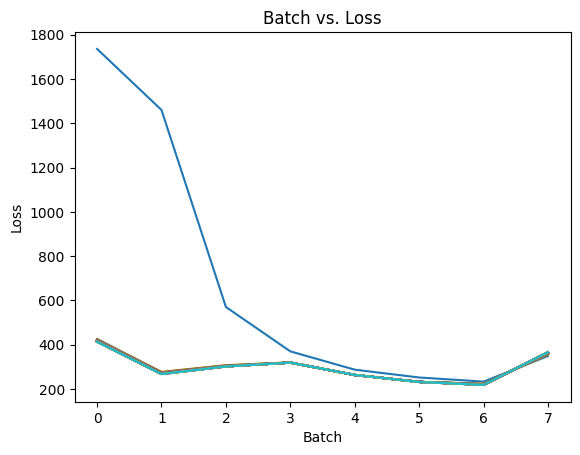

MSE Loss on test set: 338.46
MAE Loss on test set: 15.33


In [16]:
torch.manual_seed(0)

layer_one_size = train_data_torch.shape[1] * 10
layer_two_size = layer_one_size * 2

concrete_neural_network = torch.nn.Sequential(
    torch.nn.Linear(train_data_torch.shape[1], layer_one_size),
    torch.nn.Tanh(),
    torch.nn.Linear(layer_one_size, layer_two_size),
    torch.nn.Tanh(),
    torch.nn.Linear(layer_two_size, layer_one_size),
    torch.nn.Tanh(),
    torch.nn.Linear(layer_one_size, layer_one_size),
    torch.nn.Tanh(),
    torch.nn.Linear(layer_one_size, 1),
)
concrete_neural_network.to(device=device)
concrete_neural_network.train()

num_epochs = 100

batch_size = 100

learning_rate = 0.01

sgd_optimizer = torch.optim.SGD(concrete_neural_network.parameters(), learning_rate)

training_losses = []

fig, loss_ax = plt.subplots()

for epoch in range(num_epochs):
    for i in range(0, train_data_torch.shape[0], batch_size):
        X_data_matrix = train_data_torch[i:i+batch_size].to(device=device)
        y_value_vector = train_target_torch[i:i+batch_size].to(device=device)

        sgd_optimizer.zero_grad()

        predictions = concrete_neural_network(X_data_matrix)
        loss = torch.nn.functional.mse_loss(predictions.view(-1), y_value_vector)
        loss.backward()

        sgd_optimizer.step()

        training_losses.append(loss.item())
    
    loss_ax.plot(numpy.arange(len(training_losses)), training_losses)
    loss_ax.set_xlabel("Batch")
    loss_ax.set_ylabel("Loss")
    loss_ax.set_title(f"Batch vs. Loss")
    loss_ax.grid()

    training_losses.clear()

plt.show()

concrete_neural_network.eval()

X_data_matrix = test_data_torch.to(device=device)
y_label_vector = test_target_torch.to(device=device)

test_predictions = concrete_neural_network(X_data_matrix)
test_mse_loss = torch.nn.functional.mse_loss(test_predictions.view(-1), y_label_vector)

mae_loss = torch.nn.L1Loss()
test_mae_loss = mae_loss(test_predictions.view(-1), y_label_vector)

print(f"MSE Loss on test set: {test_mse_loss:.2f}")

print(f"MAE Loss on test set: {test_mae_loss:.2f}")

#### c) It is time to fine-tune your model with the aim of enhancing its performance. Implement a grid search considering the learning rate and batch size parameters. Try variations of learning rates (i.e. 0.1, 0.01, 0.001, 0.0001, etc) and batch sizes (8, 16, 32, 64, etc). Compare the results in terms of training curves and testing performance.

In [17]:
learning_rates = [0.2, 0.1, .05, .025, 0.01, 0.001]

batch_sizes = [2**i for i in range(3, 9)]

train_data_torch, val_data_torch, train_target_torch, val_target_torch = train_test_split(train_data_torch,
                                                                                            train_target_torch,
                                                                                            test_size=0.2,
                                                                                            random_state=42)

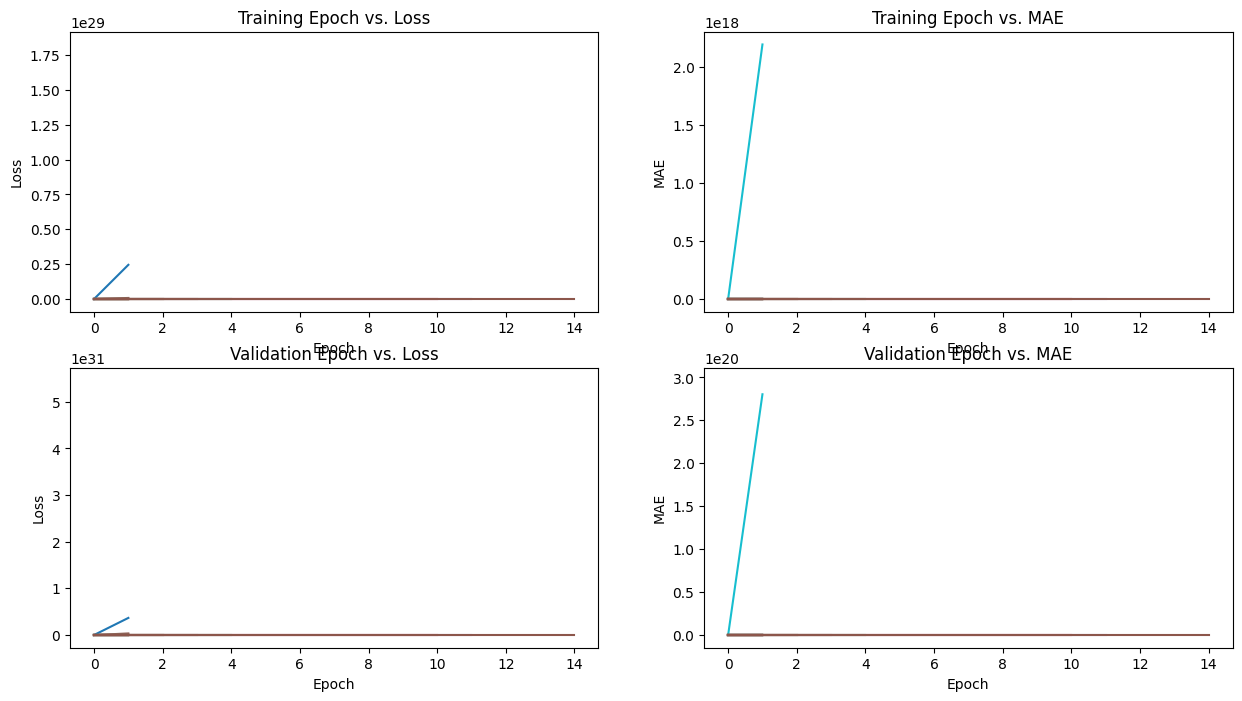

The best loss value that was found was 319.34
Config: learning rate = 0.001, batch size = 64
Loss on test set: 270.10
MAE on test set: 13.23


In [18]:
best_learning_rate = 0.0

best_batch_size = 0

current_optimized_loss = 9999999.99

current_optimized_network = None

fig, ax = plt.subplots(2,2, figsize=(15, 8))

for search_learning_rate in learning_rates:
    for search_batch_size in batch_sizes:
        torch.manual_seed(0)

        layer_one_size = train_data_torch.shape[1] * 10
        layer_two_size = layer_one_size * 2

        concrete_neural_network = torch.nn.Sequential(
            torch.nn.Linear(train_data_torch.shape[1], layer_one_size),
            torch.nn.Tanh(),
            torch.nn.Linear(layer_one_size, layer_two_size),
            torch.nn.Tanh(),
            torch.nn.Linear(layer_two_size, layer_one_size),
            torch.nn.Tanh(),
            torch.nn.Linear(layer_one_size, layer_one_size),
            torch.nn.Tanh(),
            torch.nn.Linear(layer_one_size, 1),
        )
        concrete_neural_network.to(device=device)

        sgd_optimizer = torch.optim.SGD(concrete_neural_network.parameters(), search_learning_rate)

        training_losses = []
            
        training_maes = []

        validation_losses = []
        
        validation_maes = []

        num_batches = math.ceil(len(train_data_torch) / search_batch_size)

        for epoch in range(num_epochs):
            concrete_neural_network.train()

            train_loss_tot = 0.0
            
            train_mae_tot = 0.0

            for i in range(0, train_data_torch.shape[0], search_batch_size):
                X_data_matrix = train_data_torch[i:i+batch_size].to(device=device)
                y_value_vector = train_target_torch[i:i+batch_size].to(device=device)

                sgd_optimizer.zero_grad()

                predictions = concrete_neural_network(X_data_matrix)
                loss = torch.nn.functional.mse_loss(predictions.view(-1), y_value_vector)
                loss.backward()

                sgd_optimizer.step()

                train_loss_tot += loss.item()
                
                train_mae_tot += mae_loss(predictions.view(-1), y_value_vector).item()

            training_losses.append(train_loss_tot / num_batches)
            
            training_maes.append(train_mae_tot / num_batches)

            concrete_neural_network.eval()

            val_predictions = concrete_neural_network(val_data_torch.to(device=device))
            val_mse_loss = torch.nn.functional.mse_loss(val_predictions.view(-1), val_target_torch.to(device=device))
            validation_losses.append(val_mse_loss.item())

            val_mae_loss = mae_loss(val_predictions.view(-1), val_target_torch.to(device=device)).item()
            validation_maes.append(val_mae_loss)

            if validation_losses[epoch - 1] < validation_losses[epoch]:
                if validation_losses[epoch - 1] < current_optimized_loss:
                    current_optimized_loss = validation_losses[epoch - 1]

                    current_optimized_network = concrete_neural_network

                    best_learning_rate = search_learning_rate

                    best_batch_size = search_batch_size

                break
            else:
                if validation_losses[epoch] < current_optimized_loss:
                    current_optimized_loss = validation_losses[epoch]

                    current_optimized_network = concrete_neural_network

                    best_learning_rate = search_learning_rate

                    best_batch_size = search_batch_size

        ax[0,0].plot(numpy.arange(len(training_losses)), training_losses)
        ax[0,0].set_xlabel("Epoch")
        ax[0,0].set_ylabel("Loss")
        ax[0,0].set_title(f"Training Epoch vs. Loss")
        ax[0,0].grid()
        
        ax[0,1].plot(numpy.arange(len(training_maes)), training_maes)
        ax[0,1].set_xlabel("Epoch")
        ax[0,1].set_ylabel("MAE")
        ax[0,1].set_title(f"Training Epoch vs. MAE")
        ax[0,1].grid()
        
        ax[1,0].plot(numpy.arange(len(validation_losses)), validation_losses)
        ax[1,0].set_xlabel("Epoch")
        ax[1,0].set_ylabel("Loss")
        ax[1,0].set_title(f"Validation Epoch vs. Loss")
        ax[1,0].grid()
        
        ax[1,1].plot(numpy.arange(len(validation_maes)), validation_maes)
        ax[1,1].set_xlabel("Epoch")
        ax[1,1].set_ylabel("MAE")
        ax[1,1].set_title(f"Validation Epoch vs. MAE")
        ax[1,1].grid()

        training_losses.clear()
        
        training_maes.clear()
        
        validation_losses.clear()
        
        validation_maes.clear()

plt.show()

print(f"The best loss value that was found was {current_optimized_loss:.2f}\nConfig: learning rate = {best_learning_rate}, batch size = {best_batch_size}")

current_optimized_network.eval()

test_predictions = current_optimized_network(test_data_torch.to(device=device))
test_mse_loss = torch.nn.functional.mse_loss(test_predictions.view(-1), test_target_torch.to(device=device)).item()

test_mae_loss = mae_loss(test_predictions.view(-1), test_target_torch.to(device=device)).item()

print(f"Loss on test set: {test_mse_loss:.2f}")

print(f"MAE on test set: {test_mae_loss:.2f}")

## Question 3
### Design and implement a CNN to be used in a task of Medical Image Classification. Given an image of an MRI/CT/X-ray scan, your model is to predict the body part being scanned.You are required to split the data into train and test sets with 7:3 ratio. You should design and build a simple CNN using PyTorch, and train it on the given dataset for 10 epochs. Report on your design, your choice of hyperparameters, as well as the training accuracy/loss plots. You can use scikit-learn’s classification report tool for numerical analysis.

Ave mini-batch loss for epoch 0: 3.598688
Ave mini-batch accuracy for epoch 0: 80.25%
Ave mini-batch loss for epoch 1: 0.051140
Ave mini-batch accuracy for epoch 1: 98.39%
Ave mini-batch loss for epoch 2: 0.027874
Ave mini-batch accuracy for epoch 2: 98.97%
Ave mini-batch loss for epoch 3: 0.034365
Ave mini-batch accuracy for epoch 3: 99.19%
Ave mini-batch loss for epoch 4: 0.022656
Ave mini-batch accuracy for epoch 4: 99.61%


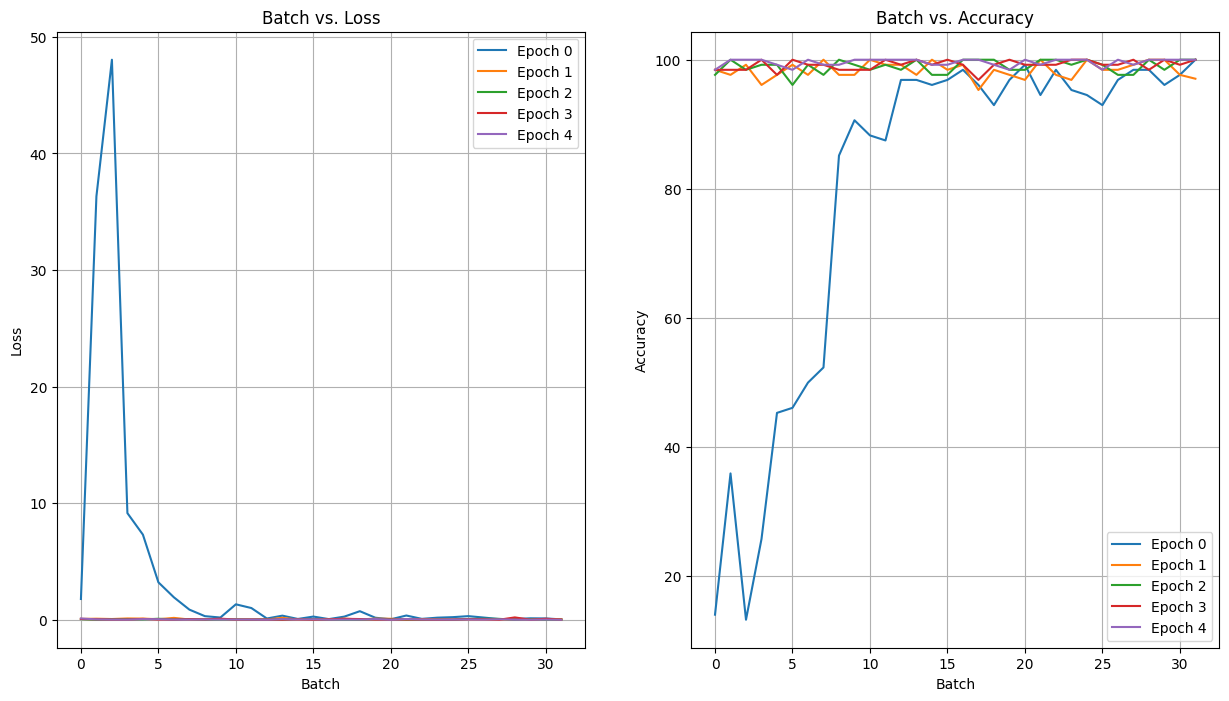

In [3]:
import torch.utils
import torch.utils.data

torch.manual_seed(0)

train_folder_contents = "C:/Users/trist/Documents/COMP 432 Code/Assignments/Assignment 2/Datasets/train"

img_batch_size = 128

img_num_epochs = 5

img_learning_rate = 0.01

img_l2_regularizer = 1e-6

img_adam_betas = (0.9, 0.999)

img_epsilon_division_stablizer = 1e-8

img_num_kernel_1 = 32

img_kernel_stride = 1

img_kernel_padding = 1

img_num_kernel_2 = 64

img_pool_size = 2

img_pool_stride = 2

img_kernel_size = 3

img_conv_neural_net = torch.nn.Sequential(
    torch.nn.Conv2d(3, img_num_kernel_1, img_kernel_size, stride=img_kernel_stride, padding=img_kernel_padding),
    torch.nn.ReLU(),
    torch.nn.Conv2d(img_num_kernel_1, img_num_kernel_2, img_kernel_size, stride=img_kernel_stride, padding=img_kernel_padding),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(img_pool_size, stride=img_pool_stride),
    torch.nn.Flatten(),
    torch.nn.Linear(img_num_kernel_2 * 32*32, 6)
)
img_conv_neural_net.to(device=device)
img_conv_neural_net.train()

img_loss_func = torch.nn.CrossEntropyLoss()

img_optimizer = torch.optim.Adam(img_conv_neural_net.parameters(),
                                 lr=img_learning_rate,
                                 betas=img_adam_betas,
                                 eps=img_epsilon_division_stablizer,
                                 weight_decay=img_l2_regularizer)

# Normalize them
img_transforms = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

# Load up the images
medical_scan_dataset = datasets.ImageFolder(train_folder_contents, transform=img_transforms)

# Put it into a data loader for batching and shuffling
img_dataloader = torch.utils.data.DataLoader(medical_scan_dataset, batch_size=img_batch_size, shuffle=True)

# Use the training loop
training_losses = []

training_accuracies = []

fig, (loss_ax, acc_ax) = plt.subplots(1,2, figsize=(15,8))

for epoch in range(img_num_epochs):
    for data, target in img_dataloader:
        data, target = data.to(device), target.to(device)

        img_optimizer.zero_grad()

        confidence_scores = img_conv_neural_net(data)
        
        loss = img_loss_func(confidence_scores, target)
        loss.backward()

        img_optimizer.step()

        training_losses.append(loss.item())
        
        label_predictions = (torch.nn.Softmax(dim=1))(confidence_scores)
        training_accuracies.append(((torch.argmax(label_predictions, dim=1) == target).sum() / len(target)).item() * 100)

    loss_ax.plot(numpy.arange(len(training_losses)), training_losses, label=f"Epoch {epoch}")
    loss_ax.set_xlabel("Batch")
    loss_ax.set_ylabel("Loss")
    loss_ax.set_title(f"Batch vs. Loss")
    loss_ax.legend()
    loss_ax.grid()

    print(f"Ave mini-batch loss for epoch {epoch}: {torch.Tensor(training_losses).mean():.6f}")
    
    print(f"Ave mini-batch accuracy for epoch {epoch}: {torch.Tensor(training_accuracies).mean():.2f}%")
    
    acc_ax.plot(numpy.arange(len(training_accuracies)), training_accuracies, label=f"Epoch {epoch}")
    acc_ax.set_xlabel("Batch")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.set_title(f"Batch vs. Accuracy")
    acc_ax.legend()
    acc_ax.grid()

    training_losses.clear()
    
    training_accuracies.clear()

plt.show()

In [4]:
import torch.utils
import torch.utils.data

img_conv_neural_net.eval()

test_folder_contents = "C:/Users/trist/Documents/COMP 432 Code/Assignments/Assignment 2/Datasets/test"

test_scan_dataset = datasets.ImageFolder(test_folder_contents, transform=img_transforms)

test_img_dataloader = torch.utils.data.DataLoader(test_scan_dataset, batch_size=img_batch_size, shuffle=True)

test_losses = []

test_accuracies = []

for data, target in test_img_dataloader:
    data, target = data.to(device), target.to(device)

    confidence_scores = img_conv_neural_net(data)
    
    loss = img_loss_func(confidence_scores, target)

    test_losses.append(loss.item())
    
    label_predictions = (torch.nn.Softmax(dim=1))(confidence_scores)
    test_accuracies.append(((torch.argmax(label_predictions, dim=1) == target).sum() / len(target)).item() * 100)

print(f"Test loss: {torch.tensor(test_losses).mean():.4f}")

print(f"Test accuracy: {torch.tensor(test_accuracies).mean():.2f}%")

Test loss: 0.0347
Test accuracy: 99.71%


#### Design Notes
- The structure of the CNN utilizes 2 convolution with ReLU activation, followed by a max pooling and finally a FCL at the end. The resoning behind the choice of design and kernel sizes comes down to the data itself. The images are very small already and so a deep CNN model wouldn't necessarily work for the simple and small dataset. Therefore, simply expanding the number of kernels and preserving the original size makes more sense. I choose the Adam optimizer as it was proven to be very useful and efficient compared to momentum and RMSProp. The result showcases that model seems to in fact be a great fit for that data, as it didn't take very long to reach near perfect accuracy scores.